<a href="https://colab.research.google.com/github/vopula/predictionCalorie/blob/linear-regression-model/regressionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

In [ ]:
import os

files = {
    "test.csv": "https://raw.githubusercontent.com/vopula/predictionCalorie/refs/heads/master/test.csv",
    "train.csv": "https://raw.githubusercontent.com/vopula/predictionCalorie/refs/heads/master/train.csv",
    "sample_submission.csv": "https://raw.githubusercontent.com/vopula/predictionCalorie/refs/heads/master/sample_submission.csv"
}

for file_name, url in files.items():
    if not os.path.exists(file_name):
        os.system(f"!wget -O {file_name} {url}")

Oke


**Problem to solve: predict how many calories were burned during a workout**

*For data scientist its all about reducing error in prediction.*

Correlation of column and target varible
1. Body_Temp is related to calories because the process creates heat and maintains a healthy baseline internal temperature (https://www.forhers.com/blog/how-to-raise-core-body-temperature-for-weight-loss)
2. Heart_Rate is related to calories because heart beats faster means muscle need more oxygen-rich blood and the body uses calorie to keep up with the extra oxygen needed (https://www.coospo.com/blogs/knowledge/calories-burned-by-heart-rate-understanding-the-connection?srsltid=AfmBOoqn33saM4wUE6pgDOfI-TY7ojgJB_SzwTnhLiMDI1fjusd0pn0_)
3. Duration is affecting calorie but up to one time because low to moderate lead to higher calorie burn but high activity some kind of conserving energy it has (https://magazine.scienceconnected.org/2021/03/more-exercise-doesnt-always-burn-more-calories/)
4. Weight does affect calorie because heavier person need more energy to move the body (https://www.livestrong.com/article/300582-do-fat-people-burn-more-calories/)
5. Height affect calorie because higher metabloc rate than short people (https://sportcoaching.co.nz/do-taller-people-burn-more-calories/)
6. Sex has affection to calorie because larger muscle mass (https://www.everydayhealth.com/fitness/factors-that-can-affect-how-many-calories-you-burn/)
7. Age do affect calorie because key hormone that promote protein systhesis become more resistant as getting older (https://www.everydayhealth.com/fitness/factors-that-can-affect-how-many-calories-you-burn/)

In [3]:
import pandas as pd, seaborn as sns, numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

# Data Preprocessing

In [22]:
data_train = pd.read_csv('../data/raw/train.csv')
data_train.head(3)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0


In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [23]:
data_test = pd.read_csv('../data/raw/test.csv')
data_test.head(3)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4


In [13]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB


In [19]:
# Conversion constants
KG_TO_POUND = 2.20462
CM_TO_INCH = lambda x: x / 2.54

# Initialize encoder
le = LabelEncoder()

# Unified BMR & RMR calculator
def calculate_bmr_rmr(row):
    sex = row['Sex']
    weight_kg = row['Weight']
    height_cm = row['Height']
    age = row['Age']
    
    weight_pounds = weight_kg * KG_TO_POUND
    height_inches = height_cm / 2.54

    if sex == 1:  # Male
        bmr = 88.362 + (13.397 * weight_kg) + (4.799 * height_cm) - (5.677 * age)
        rmr = (4.38 * weight_pounds) + (14.55 * height_inches) - (5.08 * age) + 260
    elif sex == 0:  # Female
        bmr = 447.593 + (9.247 * weight_kg) + (3.098 * height_cm) - (4.330 * age)
        rmr = (3.35 * weight_pounds) + (15.42 * height_inches) - (2.31 * age) + 43
    else:
        bmr = rmr = None

    return pd.Series([bmr, rmr])

def estimate_met_vectorized(age, hr_exercise, sex, default_vo2max_male=45, default_vo2max_female=38):
    hr_max = 220 - age
    hr_index = hr_exercise / hr_max
    vo2max = np.where(sex == 1, default_vo2max_male, default_vo2max_female)

    # Estimate VO2 and MET
    vo2 = hr_index * vo2max
    met = vo2 / 3.5

    return {
        'Estimated_MET': np.round(met, 2)
    }

def target_zones(df):
    data_fe = df.copy()
    
    data_fe['Estimated_Max_HR'] = 220 - data_fe['Age']
    data_fe['Target_zones'] = data_fe['Heart_Rate'] / data_fe['Estimated_Max_HR']
    
    return data_fe['Target_zones']

# Age grouping function
def age_grouping(df):
    bins = [17, 64, float('inf')]
    labels = ['Adults', 'Older Adults']
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    df['AgeGroups'] = le.fit_transform(df['AgeGroup'])
    df.drop(columns=['AgeGroup'], inplace=True)
    return df

def basic_preprocessing(dataset, isDataTrain=False):
    le = LabelEncoder()
    dataset_prep = dataset.copy()
    dataset_prep.drop_duplicates(inplace=True)
    dataset_prep.drop('id', axis=1, inplace=True)
    le.fit(dataset_prep.Sex.drop_duplicates())
    dataset_prep.Sex = le.transform(dataset_prep.Sex)
    
    dataset_prep[['BMR', 'RMR']] = dataset_prep.apply(calculate_bmr_rmr, axis=1)
    met_results = estimate_met_vectorized(dataset_prep['Age'], dataset_prep['Heart_Rate'], dataset_prep['Sex'])
    dataset_prep['MET'] = met_results['Estimated_MET']
    dataset_prep = age_grouping(dataset_prep)
    dataset_prep['BMI'] = dataset_prep['Weight'] / (dataset_prep['Height'] / 100) ** 2
    dataset_prep['Target_Zones'] = target_zones(dataset_prep)
    
    cols_to_scale = ['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMR', 'RMR', 'MET', 'BMI', 'Target_Zones']
    
    scaled_data = dataset_prep.copy()

    if isDataTrain:
        cols_to_scale.append('Calories')
    
    scaler = MinMaxScaler()
    scaled_data[cols_to_scale] = scaler.fit_transform(scaled_data[cols_to_scale])
            
    column_reposition = ['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMR', 'RMR', 'MET', 'BMI', 'Target_Zones']
    
    if isDataTrain:
        column_reposition.append('Calories')
        scaled_data = scaled_data[column_reposition]
        return scaled_data, scaler  # Mengembalikan dua nilai saat training
    else:
        scaled_data = scaled_data[column_reposition]
        return scaled_data  # Hanya


In [20]:
data_train, scaler = basic_preprocessing(data_train, isDataTrain=True)
data_test = basic_preprocessing(data_test)

KeyboardInterrupt: 

In [10]:
data_train.to_csv('preprocessing_train.csv')
data_test.to_csv('preprocessing_test.csv')

In [11]:
import joblib
joblib.dump(scaler, 'scaler_train.bin')

['scaler_train.bin']

In [31]:
data_train

,Unnamed: 0,Height,Weight,Duration,Heart_Rate,Body_Temp,BMR,RMR,MET,BMI,Target_Zones,Calories
0,0,0.656250,0.479167,0.862069,0.557377,0.886364,0.550364,0.600422,0.425903,0.310547,0.373451,0.476038
1,1,0.385417,0.250000,0.241379,0.295082,0.590909,0.168273,0.196999,0.283935,0.299600,0.366395,0.105431
2,2,0.364583,0.291667,0.206897,0.278689,0.613636,0.218742,0.227676,0.219178,0.361467,0.282893,0.089457
3,3,0.687500,0.562500,0.827586,0.622951,0.818182,0.673463,0.714069,0.387298,0.353355,0.331703,0.444089
4,4,0.416667,0.260417,0.827586,0.573770,0.795455,0.244265,0.252400,0.303861,0.286509,0.393574,0.463259
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,0.697917,0.635417,1.000000,0.770492,0.863636,0.704273,0.735207,0.496887,0.401110,0.451727,0.731629
749996,749996,0.406250,0.281250,0.586207,0.409836,0.772727,0.187942,0.219182,0.343711,0.315972,0.444733,0.303514
749997,749997,0.375000,0.322917,0.965517,0.754098,0.863636,0.279844,0.327854,0.677460,0.386101,0.648130,0.702875
749998,749998,0.583333,0.572917,0.551724,0.573770,0.727273,0.571162,0.601125,0.479452,0.443130,0.432710,0.345048


In [ ]:
data_train = pd.read_csv("../data/clean/preprocessing_train.csv").drop(columns='Unnamed: 0', axis=0)
data_test = pd.read_csv("../data/clean/preprocessing_test.csv").drop(columns='Unnamed: 0', axis=0)

In [12]:
# def eda_purpose(dataset):
#     dataset_prep = dataset.copy()
#     le = LabelEncoder()

#     try:
#         # changing format of Sex column from 'female' to '0', 'male' to '1'
#         le.fit(dataset_prep.Sex.drop_duplicates())
#         dataset_prep.Sex = le.transform(dataset_prep.Sex)

#         # dropping duplicate and remove unused column
#         dataset_prep.drop('id', axis=1, inplace=True)
#         dataset_prep.drop_duplicates(inplace=True)
#         dataset_prep.reset_index(inplace=True, drop=True)
#     except:
#         print('error')

#     return dataset_prep

In [13]:
# data_train = pd.read_csv('train.csv')
# data_test = pd.read_csv('test.csv')

# data_train = eda_purpose(data_train)
# data_test = eda_purpose(data_test)

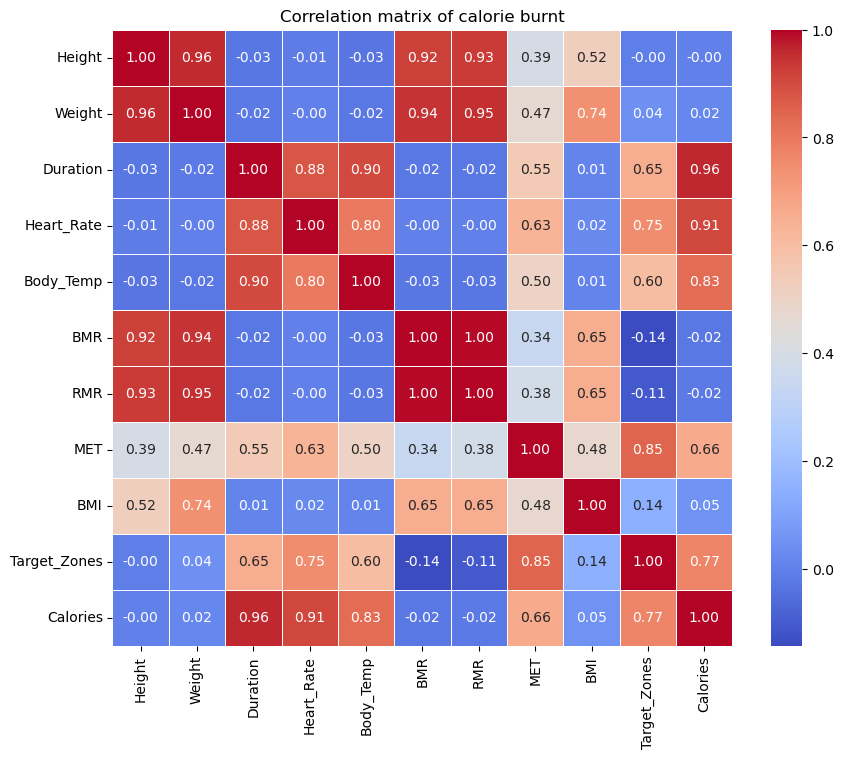

In [33]:
def correlation_visualization(dataset):
    # dataset = dataset.drop(columns=['AgeGroup'], axis=1)
    corr_matrix = dataset.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation matrix of calorie burnt')
    plt.show()

correlation_visualization(data_train)

**Lets plot correlation each column to see relationship**

Whoa, in this visualization we see
1. duration, heart_rate, body_temp correlate so much with calories burnt. They have strong correlation, this means the higher duration the more calories burnt.
2. Other variable (sex, age, height, weight) has weak to no correlation to calorie, which the more higher calorie the less they follow the same pattern as calorie burnt

lets dig down these strong correlation columns

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


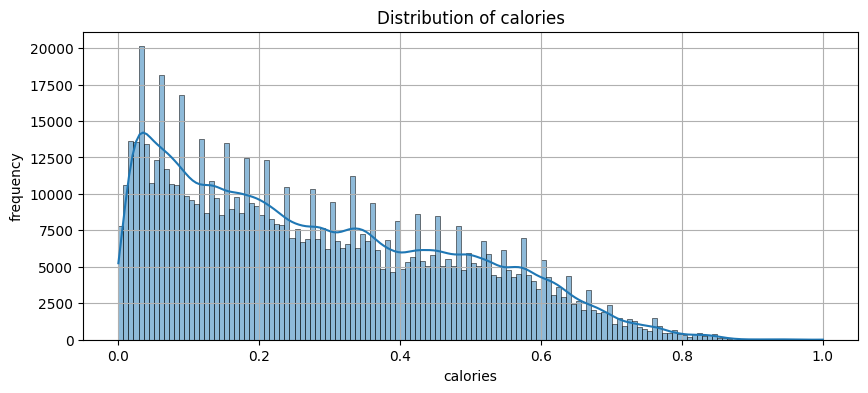

In [15]:
plt.figure(figsize=(10,4))
sns.histplot(data_train['Calories'], kde=True)
plt.title(f'Distribution of calories')
plt.xlabel('calories')
plt.ylabel('frequency')
plt.grid(True)
plt.show()

Article refference:
- https://fitliferegime.com/exercise-calories-burned-calculator/#:~:text=Several%20factors%20influence%20calorie%20burn%20during%20exercise%3A%20body,mass%2C%20and%20overall%20health%20can%20impact%20caloric%20expenditure
- https://www.fitpaa.com/blog/are-there-any-specific-exercises-or-routines-for-different-age-groups

Article info:
- Calorie = Time (hour) x 60 x MET x 3.5 x Body weight (kilogram) / 200
- Activity with engage multiple muscle group and maintain elevated heart rates can burn much calorie
- Grouping idea: Light exercise (2-4.9 METs), moderate (5.0-7.9 METs), vigorous (8.0+ METs)
- EPOC (afterburn effect), not sure what it is
- Several factors influence calorie burn during exercise: body weight, exercise intensity (MET value), duration, fitness level, and exercise type. Additionally, factors like age, muscle mass, and overall health can impact caloric expenditure
- Group age 5-17 consider children, group age 18-30 consider young adult, group age 31-64 consider adult, group age >65 consider older adult

Cut the visualization, lets try to make new feature

In [16]:
data_train

,Height,Weight,Duration,Heart_Rate,Body_Temp,BMR,RMR,MET,BMI,Target_Zones,Calories
0,0.656250,0.479167,0.862069,0.557377,0.886364,0.550364,0.600422,0.425903,0.310547,0.373451,0.476038
1,0.385417,0.250000,0.241379,0.295082,0.590909,0.168273,0.196999,0.283935,0.299600,0.366395,0.105431
2,0.364583,0.291667,0.206897,0.278689,0.613636,0.218742,0.227676,0.219178,0.361467,0.282893,0.089457
3,0.687500,0.562500,0.827586,0.622951,0.818182,0.673463,0.714069,0.387298,0.353355,0.331703,0.444089
4,0.416667,0.260417,0.827586,0.573770,0.795455,0.244265,0.252400,0.303861,0.286509,0.393574,0.463259
...,...,...,...,...,...,...,...,...,...,...,...
749995,0.697917,0.635417,1.000000,0.770492,0.863636,0.704273,0.735207,0.496887,0.401110,0.451727,0.731629
749996,0.406250,0.281250,0.586207,0.409836,0.772727,0.187942,0.219182,0.343711,0.315972,0.444733,0.303514
749997,0.375000,0.322917,0.965517,0.754098,0.863636,0.279844,0.327854,0.677460,0.386101,0.648130,0.702875
749998,0.583333,0.572917,0.551724,0.573770,0.727273,0.571162,0.601125,0.479452,0.443130,0.432710,0.345048


---

In [34]:
scaled_train = data_train.copy()
scaled_test = data_test.copy()

In [35]:
scaled_train = scaled_train[['Body_Temp', 'Heart_Rate', 'Duration', 'MET', 'Target_Zones', 'Calories']]
scaled_test = scaled_test[['Body_Temp', 'Heart_Rate', 'Duration', 'MET','Target_Zones']]

In [36]:
scaled_train.head()

,Body_Temp,Heart_Rate,Duration,MET,Target_Zones,Calories
0,0.886364,0.557377,0.862069,0.425903,0.373451,0.476038
1,0.590909,0.295082,0.241379,0.283935,0.366395,0.105431
2,0.613636,0.278689,0.206897,0.219178,0.282893,0.089457
3,0.818182,0.622951,0.827586,0.387298,0.331703,0.444089
4,0.795455,0.573770,0.827586,0.303861,0.393574,0.463259


# Modelling

## Premodelling

In [20]:
from sklearn.model_selection import train_test_split

X = scaled_train.drop('Calories', axis=1)
y = scaled_train['Calories']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [74]:
# def rmsle(y_true, y_pred):
#     """
#     Calculates the Root Mean Squared Logarithmic Error (RMSLE).
#     """
#     log_diff = np.log1p(y_pred) - np.log1p(y_true)
#     rmsle_score =  np.sqrt(np.mean(log_diff ** 2))
#     print(f"RMSLE: {rmsle_score}")
from sklearn.metrics import mean_squared_log_error
def rmsle(y_true, y_pred):
    return print(np.sqrt(mean_squared_log_error(y_true, y_pred)))

In [22]:
# def inverse_calories(y_scaled, scaler):
#     idx = scaler.feature_names_in_.tolist().index('Calories')
#     dummy_input = np.zeros((len(y_scaled), len(scaler.mean_)))
#     dummy_input[:, idx] = y_scaled
#     return scaler.inverse_transform(dummy_input)[:, idx]
def inverse_calories(y_scaled, scaler, idx=5):
    dummy_input = np.zeros((len(y_scaled), scaler.n_features_in_))
    dummy_input[:, idx] = y_scaled.ravel()
    return scaler.inverse_transform(dummy_input)[:, idx]


In [122]:
def predict_to_df(y_pred):
  df_result = pd.DataFrame({
    'id': np.arange(750000, 750000 + len(y_pred)),
    'Calories': y_pred
    })
  df_result.set_index("id", inplace=True)
  return df_result

## Linear Regression

In [80]:
from sklearn.linear_model import LinearRegression

def fitting_LinearRegressionModel(X_train, X_val, y_train, y_val):
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  # y_pred = inverse_calories(y_pred, scaler,0)
  y_pred = np.where(y_pred < 0, 0, y_pred)
  y_pred = np.round(y_pred, 3)
  rmsle(y_val, y_pred)
  return model

model_reg = fitting_LinearRegressionModel(X_train, X_val, y_train, y_val)

0.024565910262256997


In [ ]:
def predict_LinearRegressionModel(scaled_test, model):
  y_pred = model.predict(scaled_test)
  y_pred = inverse_calories(y_pred, scaler)
  y_pred = np.where(y_pred < 0, 0, y_pred)
  y_pred = np.round(y_pred, 3)
  df_pred = predict_to_df(y_pred)
  return df_pred

In [ ]:
df_pred_reg = predict_LinearRegressionModel(scaled_test, model_reg)
df_pred_reg.head()

,Calories
id,
750000,22.953
750001,121.108
750002,87.095
750003,122.222
750004,74.531


In [ ]:
df_pred_reg.to_csv("linear_reg1.csv", sep=",")
pd.read_csv("linear_reg10.csv")

,id,Calories
0,750000,22.953
1,750001,121.108
2,750002,87.095
3,750003,122.222
4,750004,74.531
...,...,...
249995,999995,14.802
249996,999996,11.841
249997,999997,72.832
249998,999998,163.527


## Random Forest

In [81]:
from sklearn.ensemble import RandomForestRegressor

def fitting_RandomForestModel(X_train, X_val, y_train, y_val):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred = inverse_calories(y_pred, scaler)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    y_pred = np.round(y_pred, 3)
    rmsle(y_val, y_pred)
    return model

model_rf = fitting_RandomForestModel(X_train, X_val, y_train, y_val)

KeyboardInterrupt: 

In [ ]:
def predict_RandomForestModel(scaled_test, model):
    y_pred = model.predict(scaled_test)
    y_pred = inverse_calories(y_pred, scaler)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    y_pred = np.round(y_pred, 3)
    df_pred = predict_to_df(y_pred)
    return df_pred

df_pred_rf = predict_RandomForestModel(scaled_test, model_rf)

In [ ]:
df_pred_rf.to_csv("random_forest1.csv", sep=",")
pd.read_csv("random_forest1.csv")

,id,Calories
0,750000,28.17
1,750001,106.49
2,750002,87.73
3,750003,128.04
4,750004,77.00
...,...,...
249995,999995,21.99
249996,999996,9.87
249997,999997,73.49
249998,999998,156.49


## Naive Bayes

### Bayesian Ridge Model

In [ ]:
from sklearn.linear_model import BayesianRidge

def fitting_BayesianRidgeModel(X_train, X_val, y_train, y_val):
    model = BayesianRidge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred = inverse_calories(y_pred, scaler)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    y_pred = np.round(y_pred, 3)
    rmsle(y_val, y_pred)
    return model

model_br = fitting_BayesianRidgeModel(X_train, X_val, y_train, y_val)


RMSLE: 0.5579724819055673


## XGBoost

In [ ]:
from xgboost import XGBRegressor

def fitting_XGBoostModel(X_train, X_val, y_train, y_val):
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred = inverse_calories(y_pred, scaler)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    y_pred = np.round(y_pred, 3)
    rmsle(y_val, y_pred)
    return model

model_xgb = fitting_XGBoostModel(X_train, X_val, y_train, y_val)


RMSLE: 0.09650518324185811


## Deeplearning

In [ ]:
!pip install scikeras
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Baseline Model

In [ ]:
from sklearn.metrics import make_scorer
def baseline_model():
    model = Sequential()
    model.add(Dense(5, input_shape=(5,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimators = [('mlp', KerasRegressor(model=baseline_model, epochs=50, batch_size=5, verbose=0))]
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
print("Standardized: %.2f (%.2f) RMSLE" % (results.mean(), results.std()))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Auto ML

In [22]:
import h2o
from h2o.automl import H2OAutoML

In [23]:
%ls

sample_submission.csv  test.csv  train.csv


In [1]:
import pandas as pd
scaled_train = pd.read_csv('preprocessing_train.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessing_train.csv'

In [24]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfi95qmtx
  JVM stdout: /tmp/tmpfi95qmtx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpfi95qmtx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_unknownUser_cyszer
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.250 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [25]:
len(scaled_train.columns)

6

In [26]:
train_h2o = h2o.H2OFrame(scaled_train)
y_h2o = 'Calories'
X_h2o = [col for col in train_h2o.columns if col != y_h2o]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [27]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=X_h2o, y=y_h2o, training_frame=train_h2o)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),20/20
# GBM base models (used / total),7/7
# XGBoost base models (used / total),6/6
# DeepLearning base models (used / total),4/4
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [28]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20250518_152250,0.0134369,0.000180551,0.00853326,0.00952001,0.000180551
GBM_4_AutoML_1_20250518_152250,0.0134582,0.000181122,0.00850454,0.00953506,0.000181122
GBM_3_AutoML_1_20250518_152250,0.0135184,0.000182746,0.00858646,0.00958404,0.000182746
GBM_1_AutoML_1_20250518_152250,0.01353,0.000183061,0.00851612,0.0095794,0.000183061
GBM_2_AutoML_1_20250518_152250,0.0135555,0.000183751,0.00863807,0.00961393,0.000183751
StackedEnsemble_BestOfFamily_1_AutoML_1_20250518_152250,0.0136119,0.000185284,0.00871417,0.0096496,0.000185284
XGBoost_grid_1_AutoML_1_20250518_152250_model_1,0.0136295,0.000185764,0.00869027,0.00967746,0.000185764
GBM_5_AutoML_1_20250518_152250,0.0136655,0.000186746,0.00872125,0.00969671,0.000186746
XGBoost_grid_1_AutoML_1_20250518_152250_model_2,0.0137257,0.000188395,0.00869924,0.00973229,0.000188395
XGBoost_grid_1_AutoML_1_20250518_152250_model_3,0.0137337,0.000188616,0.00870776,0.00975025,0.000188616


In [34]:
# Inverse transform y_true and y_pred to original scale
y_true_inv = inverse_calories(y_val, scaler)
y_pred_inv = inverse_calories(y_pred, scaler)

# Calculate RMSLE on the original scale
rmsle_score = np.sqrt(mean_squared_log_error(y_true_inv, y_pred_inv))
print("RMSLE:", rmsle_score)


RMSLE: 0.01364131700393564


/tmp/ipykernel_75/1313510467.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  dummy_input[:, idx] = y_scaled.ravel()


# Stacked Ensamble

In [37]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Base models
estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42, tree_method='hist', device='cuda'))
]

# Meta-model
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    passthrough=False,
    n_jobs=-1
)

# Training
stacking_model.fit(X_train, y_train)

# Prediksi pada data validasi
y_pred_stack = stacking_model.predict(X_val)
y_pred_stack_inv = inverse_calories(y_pred_stack, scaler)
y_pred_stack_inv = np.where(y_pred_stack_inv < 0, 0, y_pred_stack_inv)
y_pred_stack_inv = np.round(y_pred_stack_inv, 3)

# Evaluasi RMSLE
y_val_inv = inverse_calories(y_val, scaler)
from sklearn.metrics import mean_squared_log_error
rmsle_score = np.sqrt(mean_squared_log_error(y_val_inv, y_pred_stack_inv))
print("RMSLE Stacked Ensemble:", rmsle_score)

# Prediksi pada data test
y_pred_test_stack = stacking_model.predict(scaled_test)
y_pred_test_stack_inv = inverse_calories(y_pred_test_stack, scaler)
y_pred_test_stack_inv = np.where(y_pred_test_stack_inv < 0, 0, y_pred_test_stack_inv)
y_pred_test_stack_inv = np.round(y_pred_test_stack_inv, 3)

# Buat DataFrame hasil prediksi
df_pred_stack = predict_to_df(y_pred_test_stack_inv)
df_pred_stack.head()

[17:41:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:46:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarnin

RMSLE Stacked Ensemble: 0.014684888107382056


NameError: name 'predict_to_df' is not defined

# FAST AI

In [1]:
print("hello world")

hello world


In [ ]:
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *

In [ ]:
df_train_preprocess = pd.read_csv("../data/clean/preprocessing_train.csv").drop(columns="Unnamed: 0", axis=1)
df_test_preprocess = pd.read_csv("../data/clean/preprocessing_test.csv").drop(columns="Unnamed: 0", axis=1)

In [ ]:
df_train_preprocess.columns

Index(['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMR', 'RMR',
       'MET', 'BMI', 'Target_Zones', 'Calories'],
      dtype='object')

In [154]:
df_train_preprocess_trim = df_train_preprocess.iloc[:10000]

In [155]:
df_train_preprocess_trim

,Height,Weight,Duration,Heart_Rate,Body_Temp,BMR,RMR,MET,BMI,Target_Zones,Calories
0,0.656250,0.479167,0.862069,0.557377,0.886364,0.550364,0.600422,0.425903,0.310547,0.373451,0.476038
1,0.385417,0.250000,0.241379,0.295082,0.590909,0.168273,0.196999,0.283935,0.299600,0.366395,0.105431
2,0.364583,0.291667,0.206897,0.278689,0.613636,0.218742,0.227676,0.219178,0.361467,0.282893,0.089457
3,0.687500,0.562500,0.827586,0.622951,0.818182,0.673463,0.714069,0.387298,0.353355,0.331703,0.444089
4,0.416667,0.260417,0.827586,0.573770,0.795455,0.244265,0.252400,0.303861,0.286509,0.393574,0.463259
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.427083,0.291667,0.862069,0.672131,0.840909,0.267156,0.273645,0.339975,0.310325,0.439867,0.527157
9996,0.760417,0.697917,0.551724,0.606557,0.704545,0.708324,0.735768,0.503113,0.400185,0.458625,0.354633
9997,0.333333,0.260417,0.620690,0.524590,0.750000,0.237429,0.225471,0.270237,0.353975,0.349397,0.325879
9998,0.229167,0.177083,0.034483,0.213115,0.227273,0.191659,0.156957,0.113325,0.346969,0.146383,0.015974


In [156]:
cat_names =[]
cont_names = ['Body_Temp', 'Heart_Rate', 'Duration', 'MET', 'Target_Zones']
y_names = 'Calories'

In [169]:
from sklearn.model_selection import train_test_split

X = df_train_preprocess_trim[cont_names]
y = df_train_preprocess_trim[y_names]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [189]:
import torch

def rmsle_torch(preds, targets):
    preds = torch.clamp(preds, min=0)
    targets = torch.clamp(targets, min=0)
    log_preds = torch.log1p(preds)
    log_targets = torch.log1p(targets)
    return torch.sqrt(torch.mean((log_preds - log_targets) ** 2))


In [186]:
import torch
import torch.nn as nn

# Custom RMSLE loss function
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, preds, targets):
        # Pastikan prediksi dan target >= 0 untuk log
        preds = torch.clamp(preds, min=0)
        targets = torch.clamp(targets, min=0)
        loss = torch.sqrt(torch.mean((torch.log1p(preds) - torch.log1p(targets))**2))
        return loss

rmsle_loss = RMSLELoss()


In [191]:
from fastai.tabular.all import *
import torch.nn.functional as F

# --- Setup awal ---
# procs = [FillMissing, Normalize]
splits = RandomSplitter(seed=42)(range_of(df_train_preprocess_trim))

to = TabularPandas(
    df_train_preprocess_trim,
    # procs=procs,
    cont_names=cont_names,
    y_names=y_names,
    y_block=RegressionBlock(),
    splits=splits
)

# --- Parameter tuning space ---
layer_options = [[200, 100], [500, 250], [1000, 500, 100]]
lr_options = [1e-2, 5e-3, 1e-3]
wd_options = [0.01, 0.001]
epoch_options = [5, 10, 50, 100, 200]

# --- Hasil terbaik ---
best_rmsle = float('inf')
best_config = {}

# --- Loop tuning ---
for layers in layer_options:
    for lr in lr_options:
        for wd in wd_options:
            for ep in epoch_options:
                print(f"Training: layers={layers}, lr={lr}, wd={wd}, ep={ep}")
                dls = to.dataloaders(bs=128)
                learn = tabular_learner(
                    dls,
                    layers=layers,
                    loss_func=rmsle_loss,
                    metrics=rmsle_torch,
                    y_range=(0, 1),
                    wd=wd
                )
                # Train sedikit dulu untuk seleksi cepat (bisa ubah jadi fit_one_cycle)
                learn.fit(ep, lr=lr)
                val_rmsle = learn.validate()[1]

                print(f"  -> RMSLE: {val_rmsle:.5f}")
                if val_rmsle < best_rmsle:
                    best_rmsle = val_rmsle
                    best_config = {'layers': layers, 'lr': lr, 'wd': wd, 'ep' : ep}
                    print(f"*** Best configuration so far: Layers={layers}, Learning Rate={lr}, Weight Decay={wd}, Epochs={ep}, Validation RMSLE={val_rmsle:.5f} ***")
                

print("\n=== Best Configuration ===")
print(f"Layers     : {best_config['layers']}")
print(f"Learning Rate: {best_config['lr']}")
print(f"Weight Decay : {best_config['wd']}")
print(f"Epochs       : {best_config['ep']}")
print(f"Validation RMSLE: {best_rmsle:.5f}")


Training: layers=[200, 100], lr=0.01, wd=0.01, ep=5


epoch,train_loss,valid_loss,rmsle_torch,time
0,0.046428,0.032828,0.032828,00:01
1,0.028731,0.016341,0.016341,00:01
2,0.023064,0.018518,0.018518,00:01
3,0.022996,0.019061,0.019061,00:00
4,0.025199,0.013379,0.013379,00:01


  -> RMSLE: 0.01338
*** Best configuration so far: Layers=[200, 100], Learning Rate=0.01, Weight Decay=0.01, Epochs=5, Validation RMSLE=0.01338 ***
Training: layers=[200, 100], lr=0.01, wd=0.01, ep=10


epoch,train_loss,valid_loss,rmsle_torch,time
0,0.046879,0.030700,0.030700,00:01
1,0.028490,0.011937,0.011937,00:01
2,0.024442,0.016523,0.016523,00:01
3,0.022804,0.022616,0.022616,00:02
4,0.024873,0.027392,0.027392,00:01
5,0.021694,0.016569,0.016569,00:00
6,0.022281,0.017066,0.017066,00:00
7,0.021579,0.012227,0.012227,00:01
8,0.021704,0.012350,0.012350,00:01
9,0.021025,0.013130,0.013130,00:01


  -> RMSLE: 0.01313
*** Best configuration so far: Layers=[200, 100], Learning Rate=0.01, Weight Decay=0.01, Epochs=10, Validation RMSLE=0.01313 ***
Training: layers=[200, 100], lr=0.01, wd=0.01, ep=50


epoch,train_loss,valid_loss,rmsle_torch,time
0,0.042899,0.017168,0.017168,00:01
1,0.030635,0.025008,0.025008,00:00
2,0.024775,0.025499,0.025499,00:00
3,0.022293,0.015257,0.015257,00:00
4,0.024698,0.013738,0.013738,00:01
5,0.022582,0.013619,0.013619,00:02
6,0.020938,0.011686,0.011686,00:02
7,0.023110,0.014388,0.014388,00:01
8,0.021924,0.013627,0.013627,00:00
9,0.019957,0.016913,0.016913,00:01


  -> RMSLE: 0.01538
Training: layers=[200, 100], lr=0.01, wd=0.01, ep=100


epoch,train_loss,valid_loss,rmsle_torch,time
0,0.047590,0.020605,0.020605,00:01
1,0.029341,0.021502,0.021502,00:00
2,0.023927,0.011963,0.011963,00:00
3,0.022319,0.018489,0.018489,00:00
4,0.023417,0.015689,0.015689,00:00
5,0.020638,0.016561,0.016561,00:00
6,0.020594,0.010500,0.010500,00:01
7,0.022271,0.022653,0.022653,00:00
8,0.020722,0.014497,0.014497,00:01
9,0.021657,0.022792,0.022792,00:01


  -> RMSLE: 0.00954
*** Best configuration so far: Layers=[200, 100], Learning Rate=0.01, Weight Decay=0.01, Epochs=100, Validation RMSLE=0.00954 ***
Training: layers=[200, 100], lr=0.01, wd=0.01, ep=200


epoch,train_loss,valid_loss,rmsle_torch,time
0,0.046201,0.025520,0.025520,00:00
1,0.028667,0.015782,0.015782,00:00
2,0.026459,0.020238,0.020238,00:01
3,0.025734,0.018836,0.018836,00:02
4,0.022536,0.018971,0.018971,00:00
5,0.022329,0.016684,0.016684,00:00
6,0.020690,0.012757,0.012757,00:00
7,0.020209,0.013040,0.013040,00:00
8,0.019974,0.023841,0.023841,00:00
9,0.020074,0.012335,0.012335,00:00


KeyboardInterrupt: 

In [180]:
dls = to.dataloaders(bs=128)
learn = tabular_learner(
    dls,
    layers=layers,
    loss_func=F.mse_loss,
    metrics=rmse,
    y_range=(0, 1),
    wd=0.01
    )
learn.fit(100, lr=0.01)

epoch,train_loss,valid_loss,_rmse,time
0,0.007069,0.001174,0.034266,00:03
1,0.002745,0.001028,0.032069,00:01
2,0.001541,0.000484,0.021998,00:03
3,0.001127,0.000379,0.019471,00:04
4,0.001522,0.000778,0.027885,00:02
5,0.001257,0.000526,0.022924,00:02
6,0.000975,0.000538,0.023201,00:02
7,0.001239,0.000373,0.019313,00:03
8,0.000964,0.000464,0.021543,00:03
9,0.001246,0.000506,0.022497,00:03


In [160]:
preds, targs = learn.get_preds()
print(preds)

tensor([[0.4493],
        [0.2132],
        [0.2436],
        ...,
        [0.2494],
        [0.1498],
        [0.1786]])


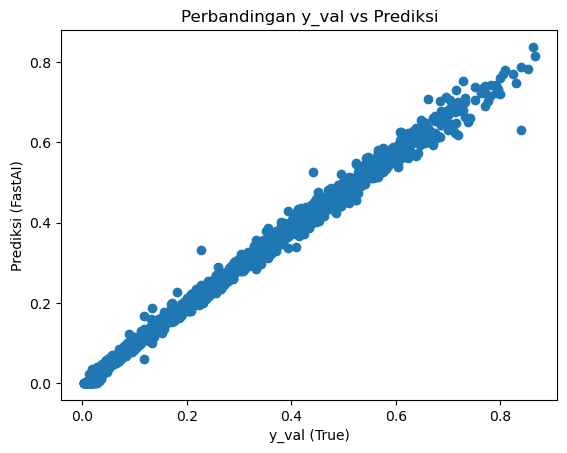

In [181]:
if not isinstance(X_val, pd.DataFrame):
    X_val = pd.DataFrame(X_val, columns=cont_names)

dl = learn.dls.test_dl(X_val)

preds, _ = learn.get_preds(dl=dl)

plt.scatter(y_val, preds.numpy())
plt.xlabel("y_val (True)")
plt.ylabel("Prediksi (FastAI)")
plt.title("Perbandingan y_val vs Prediksi")
plt.show()

In [182]:
import joblib
scaler = joblib.load("../data/clean/scaler_train.bin")

c:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [183]:
def inverse_target(preds, scaler, target_idx):
    """
    Mengembalikan prediksi ke skala asli menggunakan scaler dan indeks kolom target.
    Args:
        preds: array prediksi (1D atau 2D)
        scaler: objek MinMaxScaler yang sudah di-fit
        target_idx: indeks kolom target pada scaler
    Returns:
        Array 1D hasil inverse transform pada kolom target
    """
    import numpy as np
    dummy = np.zeros((len(preds), scaler.n_features_in_))
    dummy[:, target_idx] = np.ravel(preds)
    return scaler.inverse_transform(dummy)[:, target_idx]

In [184]:
y_preds = inverse_target(preds, scaler, 10)
y_true = inverse_target(y_val, scaler, 10)

In [185]:
rmsle(y_true, y_preds)

0.23459786115679324


In [166]:
# dl_test = learn.dls.test_dl(df_test_preprocess)

# # Mendapatkan prediksi
# test_preds, _ = learn.get_preds(dl=dl_test)

In [167]:
# test_preds = inverse_target(test_preds.numpy(), scaler, 10)

In [168]:
# df_test_preds = predict_to_df(test_preds)
# df_test_preds.to_csv("fastai_predict.csv")